**RNN과 CNN을 사용해 시퀀스 처리하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# 코랩에서 실행되는 노트북인가?
IS_COLAB = 'google.colab' in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')

# 깔끔한 그래프 출력을 위해
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, f'{fig_id}.{fig_extension}')
    print(f'그림 저장 {fig_id}')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 기본적인 RNN

## 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


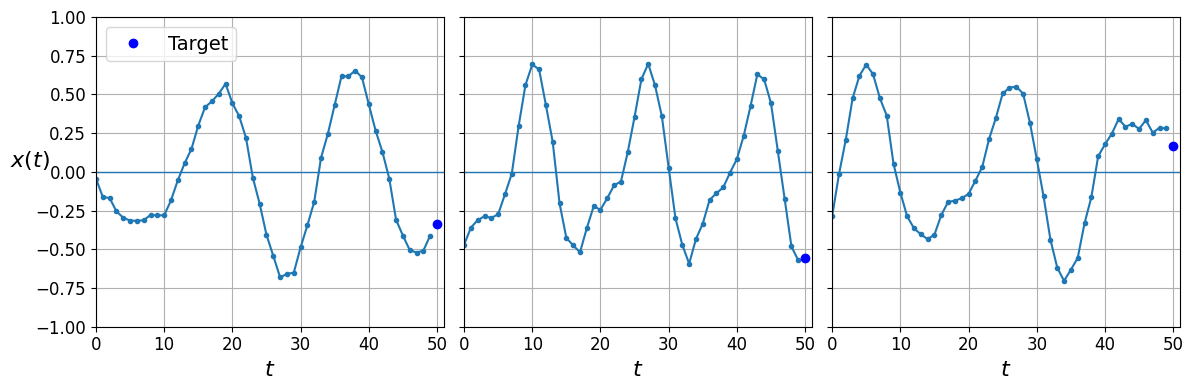

In [5]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'rx', markersize=10, label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc='upper left')


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col == 0 else None), legend=(col == 0))
save_fig('time_series_plot')
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타낸다.

## 기준 성능 계산하기

단순한 예측 (마지막 관측값을 사용해 예측한다):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.0209792

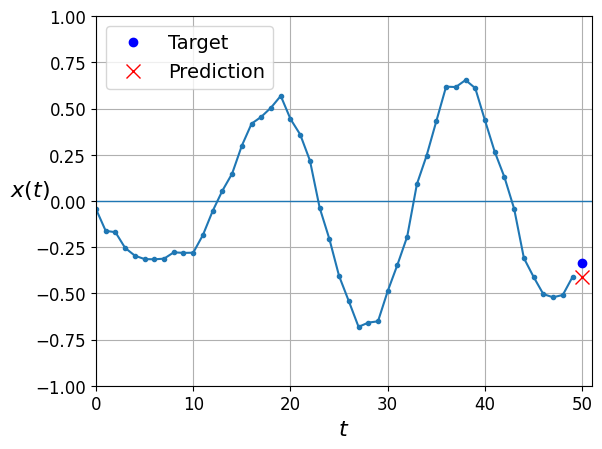

In [18]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

선형 예측:

In [22]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(1)])
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.1914 - val_loss: 0.0703
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0494 - val_loss: 0.0371
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0301 - val_loss: 0.0251
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0221 - val_loss: 0.0191
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0178 - val_loss: 0.0159
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.0138
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0134 - val_loss: 0.0122
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0088

In [23]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0047


0.004712729249149561

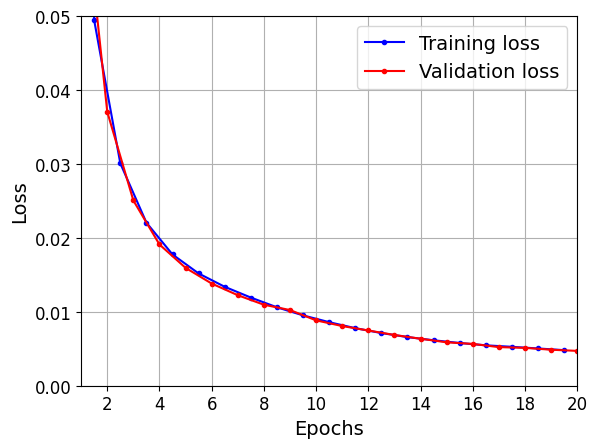

In [36]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)


plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 0s 1ms/step


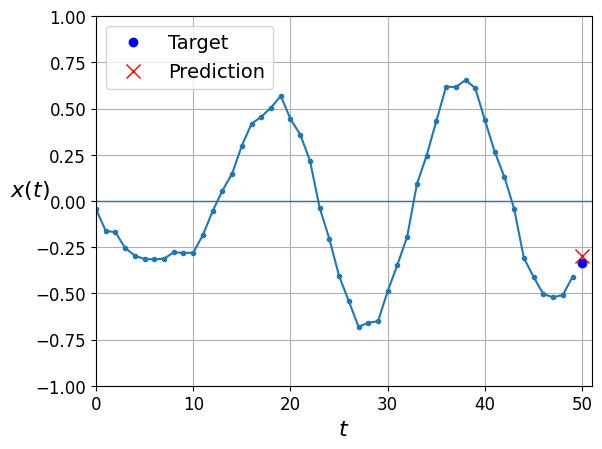

In [37]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 간단한 RNN 사용하기

In [38]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 53ms/step - loss: 0.8403 - val_loss: 0.6436
Epoch 2/20
219/219 [==============================] - 12s 53ms/step - loss: 0.2413 - val_loss: 0.0767
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0519 - val_loss: 0.0409
Epoch 4/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0329 - val_loss: 0.0293
Epoch 5/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0251 - val_loss: 0.0233
Epoch 6/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0206 - val_loss: 0.0196
Epoch 7/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 8/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 9/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 10/20
219/219 [==============================] - 12s 54ms/step - loss: 0.013

In [40]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.0113


0.01132628507912159

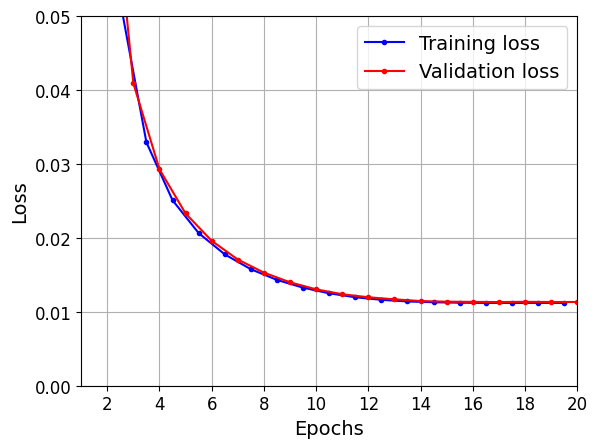

In [41]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 12ms/step


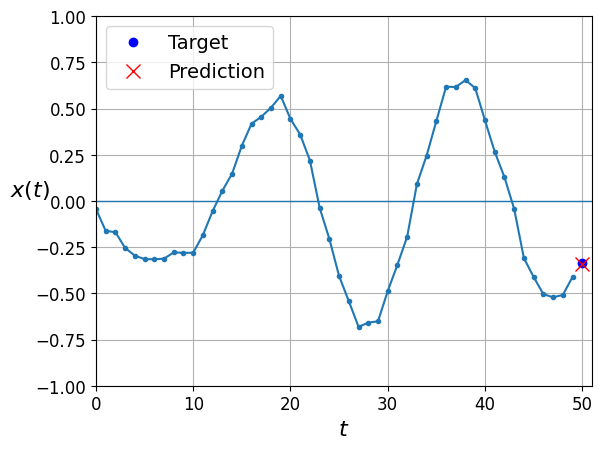

In [45]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()